# Datos de Prueba 

In [4]:
from sklearn.preprocessing import StandardScaler
from utils.ds_clean import clean_ds
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt




2024-04-11 20:49:10.442273: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 20:49:10.442530: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 20:49:10.444617: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 20:49:10.470573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 20:49:11.046425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [9]:
df_tets = clean_ds(pd.read_csv('data/aapl_5m_test.csv'))
model_buy = load_model('deep_learning/model_buy_rnn.keras')
model_sell = load_model('deep_learning/model_sell_rnn.keras')

close_data_test = df_tets[['Timestamp','Close', 'X_t-1', 'X_t-2', 'X_t-3', 'X_t-4' ,'X_t-5','RSI', 'Y_BUY']].dropna()
cl_dat_test = close_data_test.copy()

x_buy_test = cl_dat_test.drop(columns=['Timestamp','Y_BUY']).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_buy_test)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

close_data_test['Y_BUY_PRED_CNN'] = (model_buy.predict(X_reshaped)) > 0.5
close_data_test = close_data_test.drop(columns=['Y_BUY','RSI','X_t-1','X_t-2','X_t-3','X_t-4' ,'X_t-5'])
close_data_test['Y_SELL_PRED_CNN'] = (model_sell.predict(X_reshaped)) > 0.5

#convertir a booleano


614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


In [3]:
close_data_test

,Timestamp,Close,Y_BUY_PRED_CNN,Y_SELL_PRED_CNN
27,1672764300,124.849998,True,False
28,1672764600,124.599899,True,False
29,1672764900,124.742500,True,False
30,1672765200,124.730003,True,False
31,1672765500,124.930000,True,False
...,...,...,...,...
19674,1703882400,192.500000,False,False
19675,1703882700,192.510299,False,False
19676,1703883000,192.369995,False,False
19677,1703883300,192.520004,False,False


## Datos 5 minutos
- Best buy overall strategy: rnn_strategy with value: 824783.774611402
- Best buy strategy parameters: {'stop_loss': 0.03451137396108058, 'take_profit': 0.007335240907359543, 'n_shares': 9}

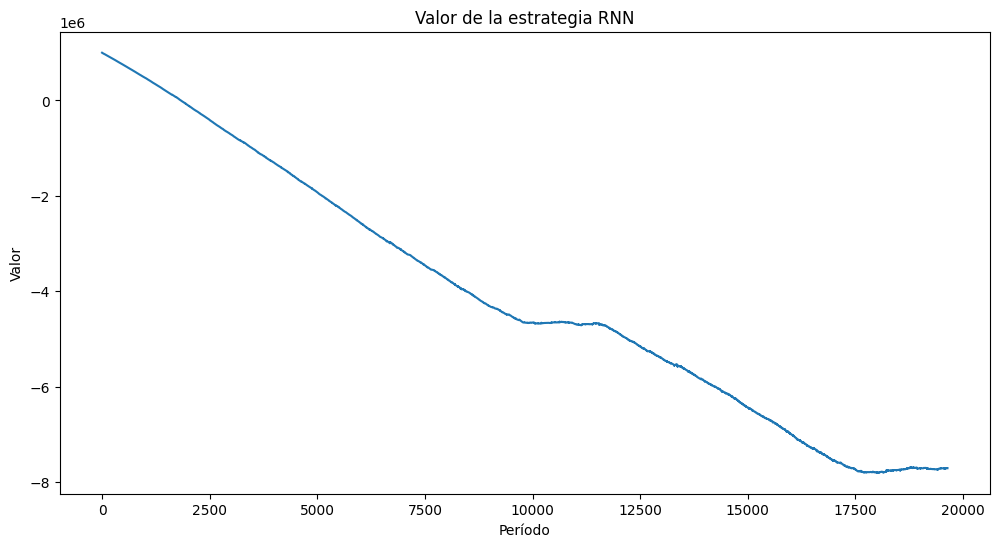

Valor de la estrategia RNN:  -7708191.3221269045


In [4]:
cash = 1_000_000
active_operations = []
com = 0.00125  # comision en GBM
strategy_value = [1_000_000]
stop_loss = 0.03451137396108058
take_profit = 0.007335240907359543
n_shares = 9

class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        # self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

for i, row in close_data_test.iterrows():
    # Close Operations
    temp_operations = []
    for op in active_operations:
        if op.operation_type == 'Long':
            if op.stop_loss > row.Close:
                cash += row.Close * op.n_shares * (1 - com)
            elif op.take_profit < row.Close:
                cash += row.Close * op.n_shares * (1 - com)
            else:
                temp_operations.append(op)
        elif op.operation_type == 'Short':
            if op.stop_loss < row.Close:
                cash -= row.Close * op.n_shares * (1 + com)
            elif op.take_profit > row.Close:
                cash -= row.Close * op.n_shares * (1 + com)
            else:
                temp_operations.append(op)
    active_operations = temp_operations

    # Open Operations
    if row.Y_BUY_PRED_CNN:
        n_shares = n_shares
        stop_loss = row.Close * (1 - stop_loss)
        take_profit = row.Close * (1 + take_profit)
        active_operations.append(
            Operation('Long', row.Close, row.Timestamp, n_shares, stop_loss, take_profit))
        cash -= row.Close * n_shares * (1 + com)
    elif row.Y_SELL_PRED_CNN:
        n_shares = n_shares
        stop_loss = row.Close * (1 + stop_loss)
        take_profit = row.Close * (1 - take_profit)
        active_operations.append(
            Operation('Short', row.Close, row.Timestamp, n_shares, stop_loss, take_profit))
        cash += row.Close * n_shares * (1 - com)

    total_value = len(active_operations) * row.Close 
    strategy_value.append(cash + total_value)
    
plt.figure(figsize=(12, 6))
plt.plot(strategy_value)
plt.title('Valor de la estrategia RNN')
plt.xlabel('Período')
plt.ylabel('Valor')
plt.show()
print("Valor de la estrategia RNN: ", strategy_value[-1])

# Datos 1 Hora

In [5]:
df_tets_1h = clean_ds(pd.read_csv('data/aapl_1h_test.csv'))
model_buy_1h = load_model('deep_learning/model_buy_dnn.keras')
model_sell_1h = load_model('deep_learning/model_sell_dnn.keras')

close_data_test_1h = df_tets_1h[['Timestamp','Close', 'X_t-1', 'X_t-2', 'X_t-3', 'X_t-4' ,'X_t-5','RSI', 'Y_BUY']].dropna()
cl_dat_test_1h = close_data_test_1h.copy()

x_buy_test_1h = cl_dat_test_1h.drop(columns=['Timestamp','Y_BUY']).values
scaler = StandardScaler()
X_scaled_1h = scaler.fit_transform(x_buy_test_1h)
#X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

close_data_test_1h['Y_BUY_PRED_DNN'] = (model_buy_1h.predict(X_scaled_1h)) > 0.5
close_data_test_1h = close_data_test_1h.drop(columns=['Y_BUY','RSI','X_t-1','X_t-2','X_t-3','X_t-4' ,'X_t-5'])
close_data_test_1h['Y_SELL_PRED_DNN'] = (model_sell_1h.predict(X_scaled_1h)) > 0.5
close_data_test_1h

  1/179 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step

2024-04-11 20:49:17.220898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-11 20:49:17.221124: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


,Timestamp,Close,Y_BUY_PRED_DNN,Y_SELL_PRED_DNN
27,1610051400,130.860000,False,False
28,1610116200,130.380004,False,False
29,1610119800,131.070007,False,False
30,1610123400,132.154998,False,False
31,1610127000,131.115005,False,False
...,...,...,...,...
5728,1703871000,191.899993,False,False
5729,1703874600,192.119995,False,False
5730,1703878200,192.679992,False,False
5731,1703881800,192.520004,False,False


- Best buy overall strategy: dnn_strategy with value: 1744158.5911437129
- Best buy strategy parameters: {'stop_loss': 0.047858368938348626, 'take_profit': 0.04204800903772516, 'n_shares': 165}

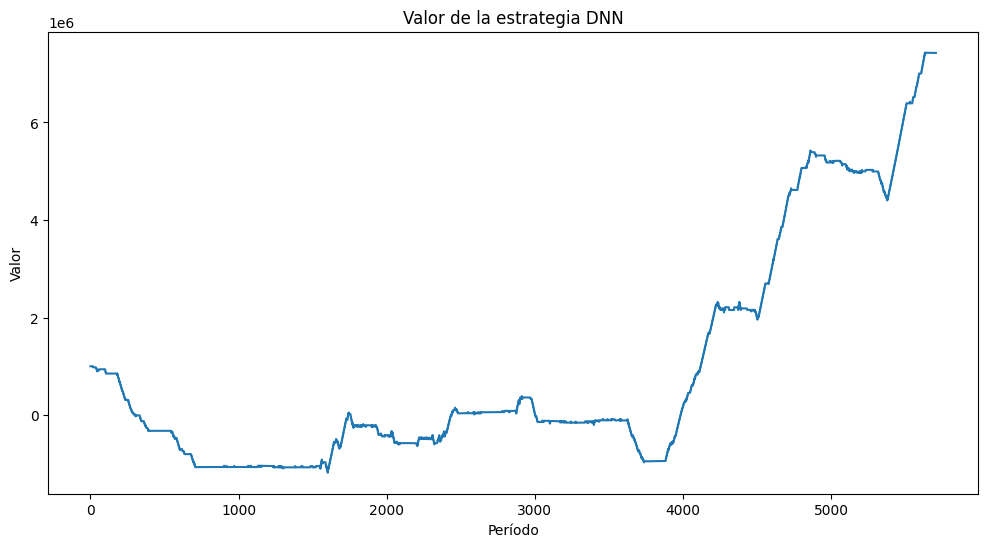

Valor de la estrategia DNN:  7426860.744007241


In [7]:
cash = 1_000_000
active_operations = []
com = 0.00125  # comision en GBM
strategy_value = [1_000_000]
stop_loss = 0.047858368938348626
take_profit = 0.04204800903772516
n_shares = 165

class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        # self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

for i, row in close_data_test_1h.iterrows():
    # Close Operations
    temp_operations = []
    for op in active_operations:
        if op.operation_type == 'Long':
            if op.stop_loss > row.Close:
                cash += row.Close * op.n_shares * (1 - com)
            elif op.take_profit < row.Close:
                cash += row.Close * op.n_shares * (1 - com)
            else:
                temp_operations.append(op)
        elif op.operation_type == 'Short':
            if op.stop_loss < row.Close:
                cash -= row.Close * op.n_shares * (1 + com)
            elif op.take_profit > row.Close:
                cash -= row.Close * op.n_shares * (1 + com)
            else:
                temp_operations.append(op)
    active_operations = temp_operations

    # Open Operations
    if row.Y_BUY_PRED_DNN:
        n_shares = n_shares
        stop_loss = row.Close * (1 - stop_loss)
        take_profit = row.Close * (1 + take_profit)
        active_operations.append(
            Operation('Long', row.Close, row.Timestamp, n_shares, stop_loss, take_profit))
        cash -= row.Close * n_shares * (1 + com)
    elif row.Y_SELL_PRED_DNN:
        n_shares = n_shares
        stop_loss = row.Close * (1 + stop_loss)
        take_profit = row.Close * (1 - take_profit)
        active_operations.append(
            Operation('Short', row.Close, row.Timestamp, n_shares, stop_loss, take_profit))
        cash += row.Close * n_shares * (1 - com)

    total_value = len(active_operations) * row.Close 
    strategy_value.append(cash + total_value)
    
plt.figure(figsize=(12, 6))
plt.plot(strategy_value)
plt.title('Valor de la estrategia DNN')
plt.xlabel('Período')
plt.ylabel('Valor')
plt.show()
print("Valor de la estrategia DNN: ", strategy_value[-1])

# Conclusiones

En este caso con los datos de 5 minutos el modelo no se ajusto de una manera adecuada, la exactitud de los modelos no pasaba mas del 51%, a lo cual se debio correr con mas epocas para ampliar su entrenamiento, es por eso que a la hora de usar datos nuevos las predicciones no son buenas y se termina perdiendo dinero.

Por otro lado tenemos los datos de 1 hora, en los cuales la exactitud del modelo fue variando hasta llegar a un 70%, es por eso que cuando usamos datos nuevos para las predicciones obtenemos mejores resultados.